## Final Project Audit IT
### Concept Drift Detection 

- Sliding Window Technique: Implement a sliding window approach to process the event log in chunks.
- Conformance Checking: Use conformance metrics like fitness and precision to evaluate the alignment of current traces with the process model.
- Regression Analysis: Apply regression analysis on conformance metrics to detect significant changes.

### Utilizing GPU with Tensorflow

In [2]:
# install a virtual environment

!python3 -m venv ~/venv-tfmetal
!source ~/venv-tfmetal/bin/activate
!python3 -m pip install -U pip

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!python3 -m pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [4]:
# install the Apple metal add-on for TensorFlow:
!python3 -m pip install tensorflow-metal

Defaulting to user installation because normal site-packages is not writeable


In [5]:
# verify that TensorFlow will utilize the GPU

import tensorflow as tf
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("Using GPU with this details: ", details)

/Users/hanna/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(



Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU with this details:  {'device_name': 'METAL'}


#### Installing Required Libraries

In [6]:
pip install pm4py pandas matplotlib seaborn scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


#### Preparing the Dataset
I'm using Travel Permit Dataset from BPI Challenge 2020 https://data.4tu.nl/datasets/db35afac-2133-40f3-a565-2dc77a9329a3 which contains the events related to travel permits (including all related events of relevant prepaid travel cost declarations and travel declarations): 7,065 cases, 86,581 events

In [7]:
import pm4py

log = pm4py.read_xes('Dataset/PermitLog.xes')

/Users/hanna/Library/Python/3.9/lib/python/site-packages/pm4py/util/dt_parsing/parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(
/Users/hanna/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 7065/7065 [00:03<00:00, 2301.23it/s]


In [35]:
# Convert the event log to a DataFrame
from pm4py.objects.conversion.log import converter as log_converter

df = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)

# Display the first few rows of the DataFrame
print(df.head())

                             id  org:resource  \
0      rv_travel permit 76455_6  STAFF MEMBER   
1      rv_travel permit 76455_7  STAFF MEMBER   
2               st_step 76459_0  STAFF MEMBER   
3               st_step 76460_0  STAFF MEMBER   
4               st_step 76461_0  STAFF MEMBER   
...                         ...           ...   
86576           st_step 13113_0  STAFF MEMBER   
86577  rv_travel permit 13108_6  STAFF MEMBER   
86578           st_step 13112_0  STAFF MEMBER   
86579           st_step 13114_0  STAFF MEMBER   
86580  rv_travel permit 13108_7  STAFF MEMBER   

                              concept:name            time:timestamp  \
0                               Start trip 2016-10-05 00:00:00+00:00   
1                                 End trip 2016-10-05 00:00:00+00:00   
2             Permit SUBMITTED by EMPLOYEE 2017-04-06 13:32:10+00:00   
3      Permit FINAL_APPROVED by SUPERVISOR 2017-04-06 13:32:28+00:00   
4        Declaration SUBMITTED by EMPLOYEE 2017-04-

Kali ini kita akan menggali lebih dalam tentang dataset yang kita gunakan dengan mencari: </br>
- **Jumlah Events**: Jumlah total event pada event log yang dihitung dari jumlah total baris pada df (DataFrame)
- **Jumlah Cases**: Jumlah process instances (cases) yang unik pada event log yang dihitung dari nilai unik yang ada pada kolom 'case:concept:name'
- **Start Activities**: Activities yang muncul pertama kali pada process instances
- **End Activities**: Activities yang muncul terakhir kali pada process instances

In [8]:
# Calculate the number of events and cases in the event log
num_events = len(df)
num_cases = df['case:concept:name'].nunique()

# Format the DataFrame to be compatible with PM4Py
event_log = pm4py.format_dataframe(df, case_id='case:concept:name', activity_key='concept:name', timestamp_key='time:timestamp')

# Identify the start and end activities in the process
start_activities = pm4py.get_start_activities(event_log)
end_activities = pm4py.get_end_activities(event_log)

print("Number of events: {}\nNumber of cases: {}".format(num_events, num_cases))
print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))


Number of events: 86581
Number of cases: 7065
Start activities: {'Permit SUBMITTED by EMPLOYEE': 6319, 'Start trip': 734, 'Permit SAVED by EMPLOYEE': 12}
End activities: {'Payment Handled': 5474, 'Send Reminder': 991, 'End trip': 453, 'Permit REJECTED by EMPLOYEE': 31, 'Permit FINAL_APPROVED by SUPERVISOR': 14, 'Declaration SAVED by EMPLOYEE': 28, 'Permit SAVED by EMPLOYEE': 4, 'Declaration REJECTED by EMPLOYEE': 28, 'Request Payment': 1, 'Declaration REJECTED by SUPERVISOR': 1, 'Permit REJECTED by MISSING': 38, 'Declaration REJECTED by MISSING': 2}


Mari kita visualisasikan dsitribusi aktivitas dari event log. Didapati bahwa frekuensi tertinggi ada pada submission, payment handling, dan request payment yang menunjukkan bahwa tiga aktivitas ini merupakan initi dari proses bisnis. Selain itu ada banyak aktivitas approval yang menunjukkan banyaknya validasi dan checking dalam tiap tahap pada proses bisnis.

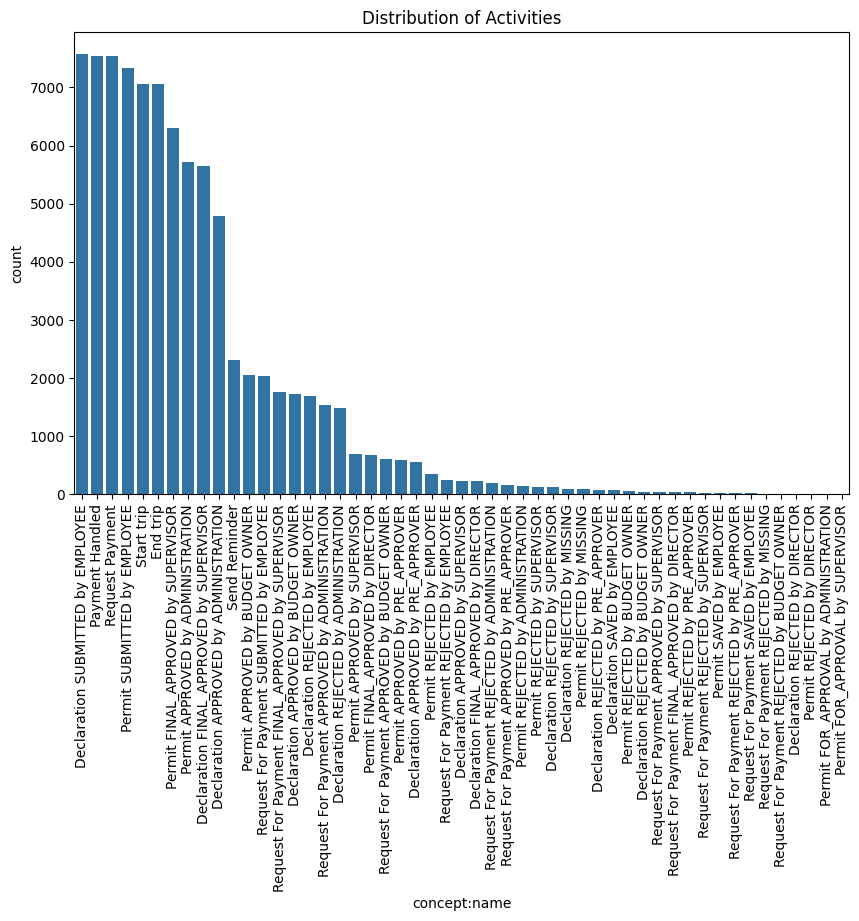

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='concept:name', order=df['concept:name'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Distribution of Activities')
plt.show()

#### Random Sampling 10% of the Original Dataset
Setelah dilakukan percobaan menggunakan dataset original dengan jumlah yang besar, dibutuhkan waktu yang lama untuk melakukan Conformance Checking, sehingga kita gunakan 10% nya dulu

In [36]:
import pandas as pd

# Randomly sample 10% of the cases
sampled_cases = df['case:concept:name'].drop_duplicates().sample(frac=0.01, random_state=42)
sampled_df = df[df['case:concept:name'].isin(sampled_cases)]
print(f"Sampled number of cases: {sampled_df['case:concept:name'].nunique()}")
print(f"Sampled number of events: {len(sampled_df)}")

Sampled number of cases: 71
Sampled number of events: 877


#### Convert Sampled DataFrame back to Event Log

In [37]:
sampled_log = pm4py.convert_to_event_log(sampled_df)

#### Data Preprocessing

In [38]:
# Check for missing values
print(sampled_df.isnull().sum())

id                  0
org:resource        0
concept:name        0
time:timestamp      0
org:role            0
                 ... 
case:Task_4       877
case:Task_9       877
case:Task_8       877
case:Task_7       877
case:Task_6       877
Length: 173, dtype: int64


In [39]:
# Fill or drop missing values
sampled_df.fillna(method='ffill', inplace=True)

/var/folders/ky/rrd0mw_95vs2vs3mxhv48gf40000gn/T/ipykernel_30217/721157272.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sampled_df.fillna(method='ffill', inplace=True)
/var/folders/ky/rrd0mw_95vs2vs3mxhv48gf40000gn/T/ipykernel_30217/721157272.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sampled_df.fillna(method='ffill', inplace=True)
/var/folders/ky/rrd0mw_95vs2vs3mxhv48gf40000gn/T/ipykernel_30217/721157272.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_df.fillna(method

#### Process Discovery
Process Discovery: The steps where you discover a process model (process tree) from the event log and convert it to a Petri net are part of the process discovery phase. This involves understanding and creating a model that represents the observed behavior in the event log.

In [40]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.objects.conversion.process_tree import converter as pt_converter

# Discover a Petri net using the Inductive Miner
process_tree = inductive_miner.apply(sampled_log)

# Convert the Process Tree to a Petri net
net, initial_marking, final_marking = pt_converter.apply(process_tree)

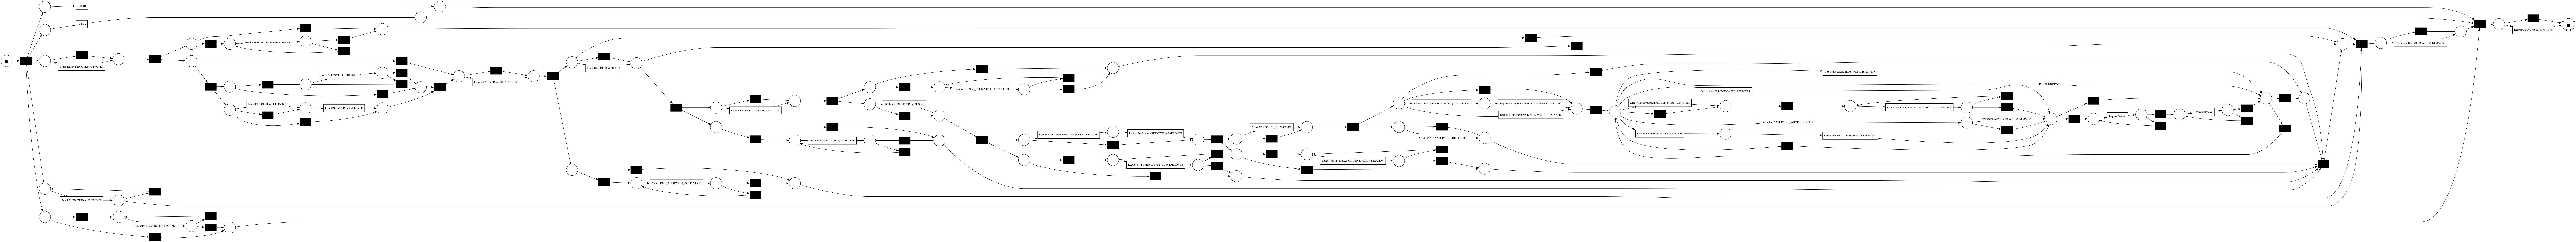

In [41]:
from pm4py.visualization.petri_net import visualizer as pn_visualizer

# Visualize the Petri net
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

#### Define Sliding Window

In [25]:
# Implement a sliding window approach to analyze the log in chunks
def sliding_window(data, window_size):
    """
    Generate chunks of the data using a sliding window approach.

    This function divides the input data into overlapping windows of a specified size. Each window
    is a subset of the data, allowing for sequential analysis in smaller, more manageable chunks.

    Parameters:
    data (iterable): The input data to be divided into windows.
    window_size (int): The size of each window (number of elements in each chunk).

    Yields:
    iterable: Subsequent windows (chunks) of the input data, each containing window_size elements.
    """
    for i in range(0, len(data) - window_size + 1):
        yield data[i:i + window_size]

In [26]:
import json

def save_checkpoint(results, filename="checkpoint.json"):
    """
    Save the checkpoint data to a JSON file.

    Parameters:
    results (list): The list of results to save.
    filename (str): The name of the checkpoint file.
    """
    with open(filename, 'w') as f:
        json.dump(results, f)

In [27]:
import os

def load_checkpoint(filename="checkpoint.json"):
    """
    Load the checkpoint data from a JSON file.

    Parameters:
    filename (str): The name of the checkpoint file.

    Returns:
    list: The list of results loaded from the checkpoint file.
    """
    if os.path.exists(filename):
        with open(filename, 'r') as f:
            return json.load(f)
    return []


#### Conformance Checking
Conformance checking techniques compare a process model with an event log of the same process. The goal is to check if the event log conforms to the model, and, vice versa. (PM4py docs) </br>

The basic idea of **Inductive Miner** is about detecting a 'cut' in the log (e.g. sequential cut, parallel cut, concurrent cut and loop cut) and then recur on sublogs, which were found applying the cut, until a base case is found. The Directly-Follows variant avoids the recursion on the sublogs but uses the Directly Follows graph.

In [28]:
from pm4py.algo.conformance.alignments.petri_net import algorithm as align

# Define the function to compute fitness
def compute_fitness(log, net, initial_marking, final_marking):
    """
    Compute the fitness of an event log with respect to a Petri net.

    This function evaluates how well the given event log conforms to the given Petri net by
    calculating the alignment between the event log and the Petri net. The fitness score is
    computed as the average fitness of all alignments.

    Parameters:
    log (pm4py.objects.log.obj.EventLog): The event log to be evaluated.
    net (pm4py.objects.petri.petrinet.PetriNet): The Petri net model.
    initial_marking (pm4py.objects.petri.petrinet.Marking): The initial marking of the Petri net.
    final_marking (pm4py.objects.petri.petrinet.Marking): The final marking of the Petri net.

    Returns:
    float: The fitness score of the event log with respect to the Petri net.
    """
    # Perform alignments between the event log and the Petri net
    alignments = align.apply(log, net, initial_marking, final_marking)
    
    # Calculate the fitness as the average fitness of all alignments
    fitness = sum(a['fitness'] for a in alignments) / len(alignments)
    
    return fitness

In [42]:
# Set the window size and create windows
window_size = 100  
windows = list(sliding_window(sampled_df, window_size))

# Load the checkpoint if it exists
checkpoint_file = "checkpoint.json"
fitness_scores = load_checkpoint(checkpoint_file)

# Determine the starting point
start_index = len(fitness_scores)

# Perform conformance checking on each window and save intermediate results
for i, window in enumerate(windows[start_index:], start=start_index):
    # Convert the window to an event log
    window_log = pm4py.convert_to_event_log(window)
    
    # Compute the fitness for the current window
    fitness = compute_fitness(window_log, net, initial_marking, final_marking)
    fitness_scores.append(fitness)
    
    # Save the checkpoint
    save_checkpoint(fitness_scores, checkpoint_file)
    
    # Print progress
    if (i + 1) % 100 == 0:
        print(f"Processed {i + 1} windows out of {len(windows)}")

# Final save after all windows are processed
save_checkpoint(fitness_scores, checkpoint_file)

print("Completed conformance checking.")
print(fitness_scores)

aligning log, completed variants ::  12%|█▎        | 1/8 [00:17<02:05, 17.89s/it]

KeyboardInterrupt: 

In [45]:
import pandas as pd
import pm4py
from pm4py.objects.log.util import dataframe_utils
from pm4py.streaming.importer.csv import importer as csv_importer

# Load the CSV event log
file_path = 'data/CCC19 - Log CSV.csv'
df = pd.read_csv(file_path)

# Convert EVENTID to datetime if it's a Unix timestamp
df['EVENTID'] = pd.to_datetime(df['EVENTID'], unit='ms')

# Rename columns to match the expected format
df.rename(columns={'CASEID': 'case:concept:name', 'ACTIVITY': 'concept:name', 'EVENTID': 'time:timestamp'}, inplace=True)

# Convert DataFrame to event log
event_log = pm4py.convert_to_event_log(df)
print(f"Original number of cases: {df['case:concept:name'].nunique()}")
print(f"Original number of events: {len(df)}")

Original number of cases: 20
Original number of events: 697


In [46]:
# Randomly sample 50% of the cases
sampled_cases = df['case:concept:name'].drop_duplicates().sample(frac=0.5, random_state=42)
sampled_df = df[df['case:concept:name'].isin(sampled_cases)]
print(f"Sampled number of cases: {sampled_df['case:concept:name'].nunique()}")
print(f"Sampled number of events: {len(sampled_df)}")

# Convert the sampled DataFrame to an event log
sampled_log = pm4py.convert_to_event_log(sampled_df)

Sampled number of cases: 10
Sampled number of events: 344


In [56]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.objects.conversion.process_tree import converter as pt_converter

# Discover a Process Tree using the Inductive Miner
process_tree = inductive_miner.apply(log)

# Convert the Process Tree to a Petri net
net, initial_marking, final_marking = pt_converter.apply(process_tree)

In [63]:
import warnings
from typing import List, Dict, Any, Union
from pm4py.objects.log.obj import EventLog, Trace, Event, EventStream
from pm4py.objects.petri_net.obj import PetriNet, Marking
from collections import Counter
from pm4py.objects.process_tree.obj import ProcessTree
from pm4py.util import xes_constants
from pm4py.utils import get_properties
import pandas as pd

def conformance_diagnostics_token_based_replay(log: EventLog, petri_net: PetriNet, initial_marking: Marking,
                                               final_marking: Marking) -> List[Dict[str, Any]]:
    """
    Apply token-based replay for conformance checking analysis.
    The methods return the full token-based-replay diagnostics.

    Parameters
    --------------
    log
        Event log
    petri_net
        Petri net
    initial_marking
        Initial marking
    final_marking
        Final marking

    Returns
    --------------
    replay_results
        A list of replay results for each trace of the log (in the same order as the traces in the event log)
    """
    if type(log) not in [pd.DataFrame, EventLog, EventStream]: raise Exception("the method can be applied only to a traditional event log!")

    from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
    return token_replay.apply(log, petri_net, initial_marking, final_marking, parameters=get_properties(log))

def conformance_diagnostics_alignments(log: EventLog, *args, multi_processing: bool = False) -> List[Dict[str, Any]]:
    """
    Apply the alignments algorithm between a log and a process model.
    The methods return the full alignment diagnostics.

    Parameters
    -------------
    log
        Event log
    args
        Specification of the process model
    multi_processing
        Boolean value that enables the multiprocessing (default: False)

    Returns
    -------------
    aligned_traces
        A list of alignments for each trace of the log (in the same order as the traces in the event log)
    """
    if type(log) not in [pd.DataFrame, EventLog, EventStream]: raise Exception("the method can be applied only to a traditional event log!")

    if len(args) == 3:
        if type(args[0]) is PetriNet:
            # Petri net alignments
            from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments
            if multi_processing:
                return alignments.apply_multiprocessing(log, args[0], args[1], args[2], parameters=get_properties(log))
            else:
                return alignments.apply(log, args[0], args[1], args[2], parameters=get_properties(log))
        elif type(args[0]) is dict or type(args[0]) is Counter:
            # DFG alignments
            from pm4py.algo.conformance.alignments.dfg import algorithm as dfg_alignment
            return dfg_alignment.apply(log, args[0], args[1], args[2], parameters=get_properties(log))
    elif len(args) == 1:
        if type(args[0]) is ProcessTree:
            # process tree alignments
            from pm4py.algo.conformance.alignments.process_tree.variants import search_graph_pt
            if multi_processing:
                return search_graph_pt.apply_multiprocessing(log, args[0], parameters=get_properties(log))
            else:
                return search_graph_pt.apply(log, args[0], parameters=get_properties(log))
    # try to convert to Petri net
    import pm4py
    from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments
    net, im, fm = pm4py.convert_to_petri_net(*args)
    if multi_processing:
        return alignments.apply_multiprocessing(log, net, im, fm, parameters=get_properties(log))
    else:
        return alignments.apply(log, net, im, fm, parameters=get_properties(log))
    
def fitness_token_based_replay(log: EventLog, petri_net: PetriNet, initial_marking: Marking, final_marking: Marking) -> \
        Dict[
            str, float]:
    """
    Calculates the fitness using token-based replay.
    The fitness is calculated on a log-based level.


    Parameters
    ---------------
    log
        Event log
    petri_net
        Petri net
    initial_marking
        Initial marking
    final_marking
        Final marking

    Returns
    ---------------
    fitness_dictionary
        dictionary describing average fitness (key: average_trace_fitness) and the percentage of fitting traces (key: percentage_of_fitting_traces)
    """
    if type(log) not in [pd.DataFrame, EventLog, EventStream]: raise Exception("the method can be applied only to a traditional event log!")

    from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness
    return replay_fitness.apply(log, petri_net, initial_marking, final_marking,
                                variant=replay_fitness.Variants.TOKEN_BASED, parameters=get_properties(log))

def fitness_alignments(log: EventLog, petri_net: PetriNet, initial_marking: Marking, final_marking: Marking, multi_processing: bool = False) -> \
        Dict[str, float]:
    """
    Calculates the fitness using alignments

    Parameters
    --------------
    log
        Event log
    petri_net
        Petri net object
    initial_marking
        Initial marking
    final_marking
        Final marking
    multi_processing
        Boolean value that enables the multiprocessing (default: False)

    Returns
    ---------------
    fitness_dictionary
        dictionary describing average fitness (key: average_trace_fitness) and the percentage of fitting traces (key: percentage_of_fitting_traces)
    """
    if type(log) not in [pd.DataFrame, EventLog, EventStream]: raise Exception("the method can be applied only to a traditional event log!")

    from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness
    parameters = get_properties(log)
    parameters["multiprocessing"] = multi_processing
    return replay_fitness.apply(log, petri_net, initial_marking, final_marking,
                                variant=replay_fitness.Variants.ALIGNMENT_BASED, parameters=parameters)

def precision_token_based_replay(log: EventLog, petri_net: PetriNet, initial_marking: Marking,
                                 final_marking: Marking) -> float:
    """
    Calculates the precision precision using token-based replay

    Parameters
    --------------
    log
        Event log
    petri_net
        Petri net object
    initial_marking
        Initial marking
    final_marking
        Final marking

    Returns
    --------------
    precision
        float representing the precision value
    """
    if type(log) not in [pd.DataFrame, EventLog, EventStream]: raise Exception("the method can be applied only to a traditional event log!")

    from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
    return precision_evaluator.apply(log, petri_net, initial_marking, final_marking,
                                     variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN, parameters=get_properties(log))



def precision_alignments(log: EventLog, petri_net: PetriNet, initial_marking: Marking,
                         final_marking: Marking, multi_processing: bool = False) -> float:
    """
    Calculates the precision of the model w.r.t. the event log using alignments

    Parameters
    --------------
    log
        Event log
    petri_net
        Petri net object
    initial_marking
        Initial marking
    final_marking
        Final marking
    multi_processing
        Boolean value that enables the multiprocessing (default: False)

    Returns
    --------------
    precision
        float representing the precision value
    """
    if type(log) not in [pd.DataFrame, EventLog, EventStream]: raise Exception("the method can be applied only to a traditional event log!")

    from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
    parameters = get_properties(log)
    parameters["multiprocessing"] = multi_processing
    return precision_evaluator.apply(log, petri_net, initial_marking, final_marking,
                                     variant=precision_evaluator.Variants.ALIGN_ETCONFORMANCE,
                                     parameters=parameters)

def __convert_to_fp(*args) -> Union[List[Dict[str, Any]], Dict[str, Any]]:
    """
    Internal method to convert the provided event log / process model argument
    to footprints (using footprints discovery)

    Parameters
    ----------------
    args
        Event log / process model

    Returns
    ---------------
    fp
        Footprints
    """
    import pm4py
    while type(args) is tuple:
        if len(args) == 1:
            args = args[0]
        else:
            fp = pm4py.discover_footprints(*args)
            return fp
    if type(args) is list or type(args) is dict:
        return args
    fp = pm4py.discover_footprints(args)
    return fp


def conformance_diagnostics_footprints(*args) -> Union[List[Dict[str, Any]], Dict[str, Any]]:
    """
    Provide conformance checking diagnostics using footprints

    Parameters
    ----------------
    args
        Provided argument:
        - The first argument is supposed to be an event log (or the footprints discovered from the event log)
        - The other arguments are supposed to be the process model (or the footprints discovered from the process model)

    Returns
    ----------------
    fps
        Footprints of the event log / process model
    """
    fp1 = __convert_to_fp(args[0])
    fp2 = __convert_to_fp(args[1:])
    from pm4py.algo.conformance.footprints import algorithm as footprints_conformance
    if isinstance(fp1, list):
        return footprints_conformance.apply(fp1, fp2, variant=footprints_conformance.Variants.TRACE_EXTENSIVE)
    else:
        return footprints_conformance.apply(fp1, fp2, variant=footprints_conformance.Variants.LOG_EXTENSIVE)



def fitness_footprints(*args) -> Dict[str, float]:
    """
    Calculates fitness using footprints

    Parameters
    ----------------
    args
        Provided argument:
        - The first argument is supposed to be an event log (or the footprints discovered from the event log)
        - The other arguments are supposed to be the process model (or the footprints discovered from the process model)

    Returns
    ----------------
    fitness_dict
        A dictionary containing two keys:
        - perc_fit_traces => percentage of fit traces (over the log)
        - log_fitness => the fitness value over the log
    """
    fp_conf = conformance_diagnostics_footprints(*args)
    fp1 = __convert_to_fp(args[0])
    fp2 = __convert_to_fp(args[1:])
    from pm4py.algo.conformance.footprints.util import evaluation
    return evaluation.fp_fitness(fp1, fp2, fp_conf)



def precision_footprints(*args) -> float:
    """
    Calculates precision using footprints

    Parameters
    ----------------
    args
        Provided argument:
        - The first argument is supposed to be an event log (or the footprints discovered from the event log)
        - The other arguments are supposed to be the process model (or the footprints discovered from the process model)

    Returns
    ----------------
    precision
        The precision of the process model (as a number between 0 and 1)
    """
    fp1 = __convert_to_fp(args[0])
    fp2 = __convert_to_fp(args[1:])
    from pm4py.algo.conformance.footprints.util import evaluation
    return evaluation.fp_precision(fp1, fp2)



def __check_is_fit_process_tree(trace, tree, activity_key=xes_constants.DEFAULT_NAME_KEY):
    """
    Check if a trace object is fit against a process tree model

    Parameters
    -----------------
    trace
        Trace
    tree
        Process tree
    activity_key
        Activity key (optional)

    Returns
    -----------------
    is_fit
        Boolean value (True if the trace fits; False if the trace does not)
    """
    from pm4py.discovery import discover_footprints
    log = EventLog()
    log.append(trace)
    fp_tree = discover_footprints(tree)
    fp_log = discover_footprints(log)
    fp_conf_res = conformance_diagnostics_footprints(fp_log, fp_tree)[0]
    # CHECK 1) if footprints already say is not fit, then return False
    # (if they say True, it might be a false positive)
    if not fp_conf_res["is_footprints_fit"]:
        return False
    else:
        from pm4py.convert import convert_to_petri_net
        net, im, fm = convert_to_petri_net(tree)
        tbr_conf_res = conformance_diagnostics_token_based_replay(log, net, im, fm)[0]
        # CHECK 2) if TBR says that is fit, then return True
        # (if they say False, it might be a false negative)
        if tbr_conf_res["trace_is_fit"]:
            return True
        else:
            # CHECK 3) alignments definitely say if the trace is fit or not if the previous methods fail
            align_conf_res = conformance_diagnostics_alignments(log, tree)[0]
            return align_conf_res["fitness"] == 1.0


def __check_is_fit_petri_net(trace, net, im, fm, activity_key=xes_constants.DEFAULT_NAME_KEY):
    """
    Checks if a trace object is fit against Petri net object

    Parameters
    ----------------
    trace
        Trace
    net
        Petri net
    im
        Initial marking
    fm
        Final marking
    activity_key
        Activity key (optional)

    Returns
    -----------------
    is_fit
        Boolean value (True if the trace fits; False if the trace does not)
    """
    # avoid checking footprints on Petri net (they are too slow)
    activities_model = set(trans.label for trans in net.transitions if trans.label is not None)
    activities_trace = set([x[activity_key] for x in trace])
    diff = activities_trace.difference(activities_model)
    if diff:
        # CHECK 1) there are activities in the trace that are not in the model
        return False
    else:
        log = EventLog()
        log.append(trace)
        tbr_conf_res = conformance_diagnostics_token_based_replay(log, net, im, fm)[0]
        # CHECK 2) if TBR says that is fit, then return True
        # (if they say False, it might be a false negative)
        if tbr_conf_res["trace_is_fit"]:
            return True
        else:
            # CHECK 3) alignments definitely say if the trace is fit or not if the previous methods fail
            align_conf_res = conformance_diagnostics_alignments(log, net, im, fm)[0]
            return align_conf_res["fitness"] == 1.0


def check_is_fitting(*args, activity_key=xes_constants.DEFAULT_NAME_KEY):
    """
    Checks if a trace object is fit against a process model

    Parameters
    -----------------
    trace
        Trace object (trace / variant)
    model
        Model (process tree, Petri net, BPMN, ...)
    activity_key
        Activity key (optional)

    Returns
    -----------------
    is_fit
        Boolean value (True if the trace fits; False if the trace does not)
    """
    from pm4py.util import variants_util
    from pm4py.convert import convert_to_process_tree, convert_to_petri_net

    trace = args[0]
    model = args[1:]

    try:
        model = convert_to_process_tree(*model)
    except:
        # the model cannot be expressed as a process tree, let's say if at least can be expressed as a Petri net
        model = convert_to_petri_net(*model)

    if not isinstance(trace, Trace):
        activities = variants_util.get_activities_from_variant(trace)
        trace = Trace()
        for act in activities:
            trace.append(Event({activity_key: act}))

    if isinstance(model, ProcessTree):
        return __check_is_fit_process_tree(trace, model, activity_key=activity_key)
    elif isinstance(model, tuple) and isinstance(model[0], PetriNet):
        return __check_is_fit_petri_net(trace, model[0], model[1], model[2], activity_key=activity_key)

In [ ]:

# Load Petri net
net, initial_marking, final_marking = 'data/CCC19 - Model PN.pnml'

# Check conformance using token-based replay
conformance_results = conformance_diagnostics_token_based_replay(log, net, initial_marking, final_marking)
print(conformance_results)

# Calculate fitness
fitness_results = fitness_token_based_replay(log, net, initial_marking, final_marking)
print(fitness_results)

# Calculate precision
precision_results = precision_token_based_replay(log, net, initial_marking, final_marking)
print(precision_results)

In [48]:
# Set the window size and create windows
window_size = 100  # Adjust based on your analysis
windows = list(sliding_window(sampled_df, window_size))

# Load the checkpoint if it exists
checkpoint_file = "checkpoint.json"
fitness_scores = load_checkpoint(checkpoint_file)

# Determine the starting point
start_index = len(fitness_scores)

# Perform conformance checking on each window and save intermediate results
for i, window in enumerate(windows[start_index:], start=start_index):
    # Convert the window to an event log
    window_log = pm4py.convert_to_event_log(window)
    
    # Compute the fitness for the current window
    fitness = compute_fitness(window_log, net, initial_marking, final_marking)
    fitness_scores.append(fitness)
    
    # Save the checkpoint
    save_checkpoint(fitness_scores, checkpoint_file)
    
    # Print progress
    if (i + 1) % 100 == 0:
        print(f"Processed {i + 1} windows out of {len(windows)}")

# Final save after all windows are processed
save_checkpoint(fitness_scores, checkpoint_file)

print("Completed conformance checking.")
print(fitness_scores)

aligning log, completed variants ::  67%|██████▋   | 2/3 [00:05<00:02,  2.76s/it]

KeyboardInterrupt: 

In [59]:
# Perform conformance checking
fitness = compute_fitness(event_log, net, initial_marking, final_marking)
print(f"Fitness: {fitness}")

aligning log, completed variants :: 100%|██████████| 20/20 [00:00<00:00, 58.14it/s]

Fitness: 0.0


In [61]:
from sklearn.linear_model import LinearRegression
import numpy as np

def detect_drifts(fitness_scores, threshold=0.05):
    changes = []
    X = np.arange(len(fitness_scores)).reshape(-1, 1)
    y = np.array(fitness_scores).reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    slope = reg.coef_[0][0]
    if abs(slope) > threshold:
        changes.append(slope)
    return changes

drifts = detect_drifts(fitness_scores)
print("Detected drifts: ", drifts)

Detected drifts:  []
